# JetRail Time Series Analysis

JetRail is a company that has devised a new way of travel. On on of its test phases, it has recorded the traffic data in chunks of hourly use. This dataset has been obtained from [AnalyticsVidya](https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/#ProblemStatement). It consists of 18288 rows and 3 features indexed by timestamps. 

The goal is to predict the sales for the next 7 months.

In [355]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import sqrt
import warnings                 
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,ARMA,acf,pacf
from statsmodels.tsa.arima_model import ARIMA

## Data Description

Lets import the data and check for sanity.

In [2]:
!ls

sample_submission.csv  Test.csv  Train.csv  ts_pred.ipynb


In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission_format = pd.read_csv('sample_submission.csv')

In [4]:
print('Size of train.csv:',train.shape)
print('Size of test.csv:',test.shape)

Size of train.csv: (18288, 3)
Size of test.csv: (5112, 2)


In [5]:
print('Features ->',train.columns)

Features -> Index(['ID', 'Datetime', 'Count'], dtype='object')


In [6]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


Check for NaNs in train and test

In [7]:
train.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [8]:
test.isnull().sum()

ID          0
Datetime    0
dtype: int64

This looks like a very clean datasets. It is primely set to completely focus on time series anlysis.

In [9]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [10]:
test.dtypes

ID           int64
Datetime    object
dtype: object

We must covnert the Datetime feature to a datetime datatype before beginning exploration.

In [11]:
train['Datetime'] = pd.to_datetime(train['Datetime'],format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'],format='%d-%m-%Y %H:%M')

In [12]:
train.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object

In [13]:
test.dtypes

ID                   int64
Datetime    datetime64[ns]
dtype: object

## Exploratory Data Analysis

### Datetime

Since we essentialy just have two features to lets start with the main event. The time. We can extract a lot of information from the timestamp. Each of them individdually can act as a good predictor for us. So let us engineer these new feeatures.

In [14]:
train['Datetime'].describe()

count                   18288
unique                  18288
top       2012-11-11 10:00:00
freq                        1
first     2012-08-25 00:00:00
last      2014-09-25 23:00:00
Name: Datetime, dtype: object

In [15]:
test['Datetime'].describe()

count                    5112
unique                   5112
top       2015-01-10 19:00:00
freq                        1
first     2014-09-26 00:00:00
last      2015-04-26 23:00:00
Name: Datetime, dtype: object

So the training data is around 2 years and a month long. While the test data is 7 months. 

Let us extract the years from the timestamp and create a new feature. We can hypothesize that as the years go on, the traffic would also go up.

In [16]:
train['year'] = train['Datetime'].dt.year
test['year'] = test['Datetime'].dt.year

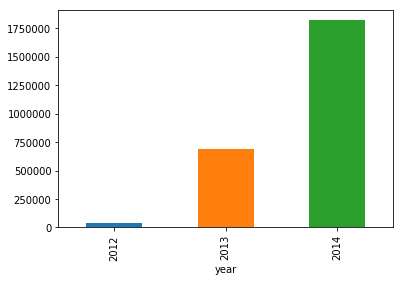

In [17]:
train.groupby('year')['Count'].sum().plot(kind='bar')

Wow thats a huge growth. Our hypothesis is correct. It looks like traffic increased by more than a 130% after 2013. But remmber, the data is from August 2012 to September 2014. This means 2013 has more records than 2014 and 2012. Which might be why the trend is such. Let us see the disparity and try plotting the means. 

In [18]:
train.groupby('year')['Count'].count()

year
2012    3096
2013    8760
2014    6432
Name: Count, dtype: int64

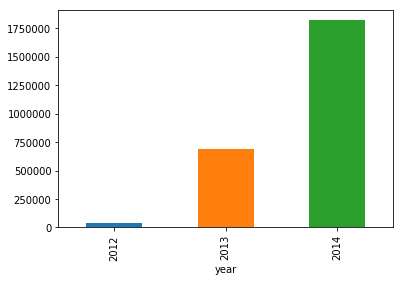

In [19]:
train.groupby('year')['Count'].sum().plot(kind='bar')

So our hypothesis still holds. Even with the means the trend cannot be any more clear.

Now let us see how traffic is spread among the months. We may get to see certain trends. There are always months where tourists visit and there is a definite increase in traffic. 

In [20]:
train['month'] = train['Datetime'].dt.month
test['month'] = test['Datetime'].dt.month

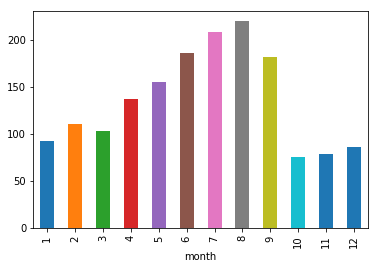

In [21]:
train.groupby('month')['Count'].mean().plot(kind='bar')

Ok so there is definitely a distinct trend. In fact it looks like Oct, Nov and Dec lost more than half the traffic. Maybe its winter and people dont go out ?. Maybe not. Naturally 2014 is the heaviest year and the data ends at September. And we are losing out because of the loss of data.

In [22]:
train.pivot_table(values='Count',index='year',columns='month',aggfunc='sum')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496.0,3200.0,8174.0,11396.0,11666.0
2013,13712.0,14912.0,17550.0,24772.0,33936.0,41280.0,55642.0,74502.0,86936.0,104110.0,101520.0,117096.0
2014,124400.0,134536.0,136892.0,173488.0,196786.0,227602.0,255456.0,290146.0,281060.0,NaN,NaN,NaN


Yes it figures. The lack of data in the last 3 months of 2014 may very well be the reason why the average is so low.

Now let us extract the days from the Timestamp. We can do a similar thing and chec the average Counts throughtout the month.

In [23]:
train['day'] = train['Datetime'].dt.day
test['day'] = test['Datetime'].dt.day

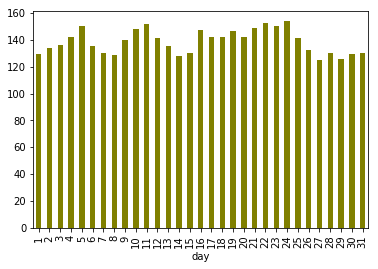

In [24]:
train.groupby('day')['Count'].mean().plot(kind='bar',color='olive')

Seems to be fairly evenly distributed. But maybe its not the day of the month but the day of the week that matters more. Afterall the weekends might have a much lower count as a lot of commuters are office goers.

Lets see what we get from the days of the week

In [25]:
train['day_of_week'] = train['Datetime'].dt.dayofweek
test['day_of_week'] = test['Datetime'].dt.dayofweek

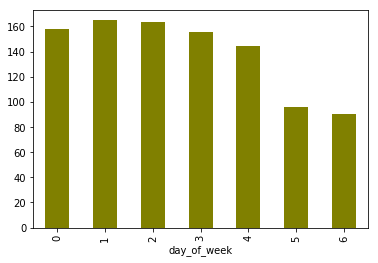

In [26]:
train.groupby('day_of_week')['Count'].mean().plot(kind='bar',color='olive')

Our hypothesis is correct. The weekends have a much lower mean count as compared to the weekdays

Let us see what we specifically get for weekdays and weekends

In [27]:
train ['weekend'] = train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
test ['weekend'] = test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

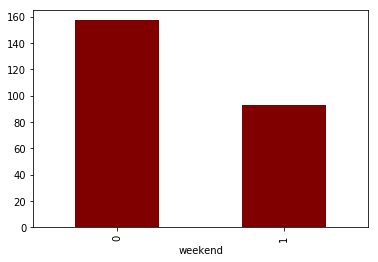

In [28]:
train.groupby('weekend')['Count'].mean().plot(kind='bar',color='maroon')

Traffic on the weekends is significantly lower !

Which leaves us with hourly data. Naturally, we can assume that the night times would have the lowest traffic. We can expect a huge  peak during Office starting and finishing hours. Lets check it out

In [29]:
train['hour'] = train['Datetime'].dt.hour
test['hour'] = test['Datetime'].dt.hour

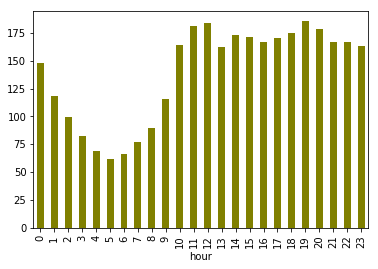

In [30]:
train.groupby('hour')['Count'].mean().plot(kind='bar',color='olive')

Seems about right !. The traffic is hot throughout the day but peaks arounf 11AM and 7PM due to office employee load. It tapers off throughout the night and starts picking up after 7AM.

That should be enough feature engineering. Let us look at the timseries plot for the full range of our training data.

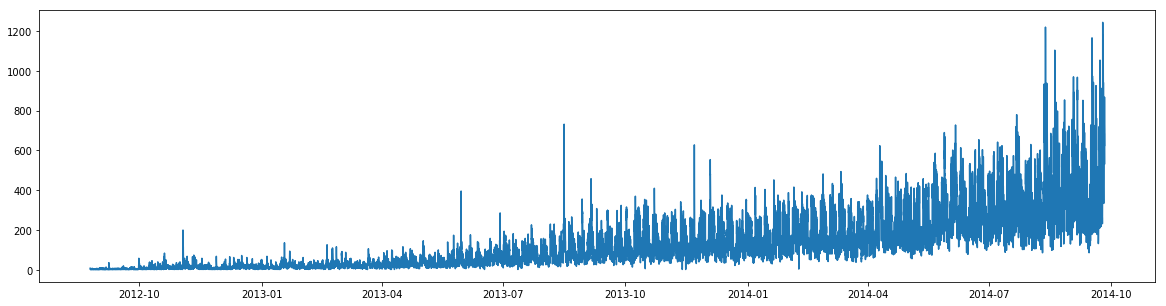

In [31]:
fig = plt.figure(figsize=(20,5))
plt.plot(train.Datetime,train.Count)

It looks very noisy. We can only infer that there is a definite upward trend as well as roughly periodic spikes due to some factor.

Lets try to resample the data to get a clear plot and observe trends better. We can take hourly, daily, weekly and monthly data, group them together and plot the timestamps.

In [32]:
train['TimeStamp'] = pd.to_datetime(train.Datetime)
train.index = train.TimeStamp

In [33]:
hour = train.resample('H')['Count'].mean()
daily = train.resample('D')['Count'].mean()
weekly = train.resample('W')['Count'].mean()
monthly = train.resample('M')['Count'].mean()

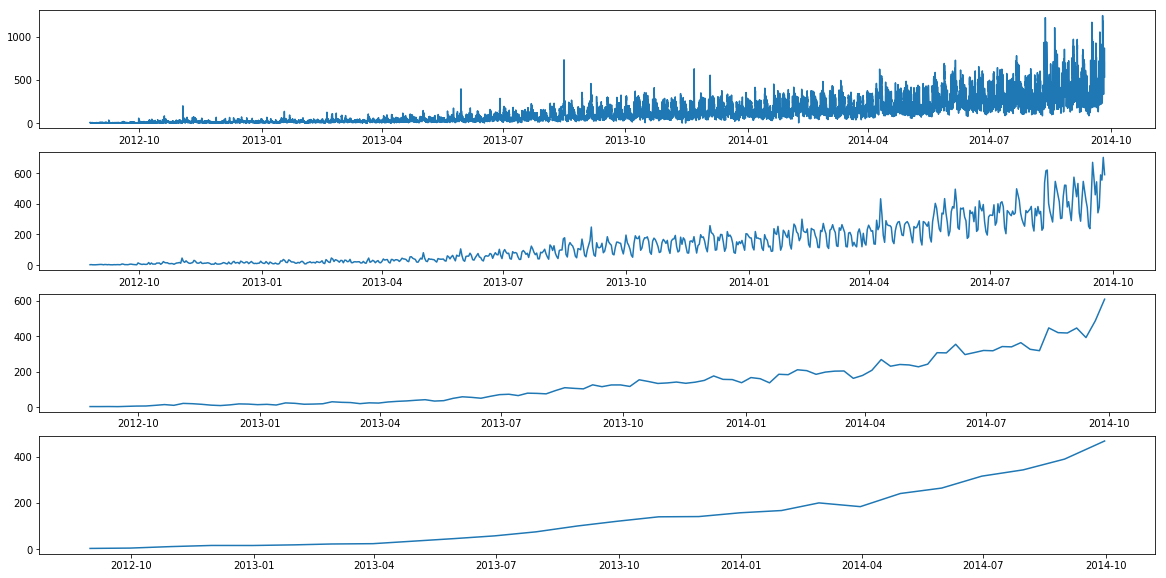

In [34]:
fig, axes = plt.subplots(4,1,figsize=(20,10))
axes[0].plot(hour)
axes[1].plot(daily)
axes[2].plot(weekly)
axes[3].plot(monthly)

This looks much more clear. In fact, the hourly plot is the same as the one above because hour is the lowest unit of time in the data. But it looks much more clear in the latter three.

Let us keep the daily resampled data. It fits well in the threshold of clarity and size of data. To be mmore clear, if we were to resample weekly and montly, we lose out on a lot of data. 

In [35]:
test['TimeStamp'] = pd.to_datetime(test.Datetime)
test.index = test.TimeStamp

In [36]:
train.drop('ID',1,inplace=True)

In [37]:
train_resampled = train.resample('D').mean()
test_resampled = test.resample('D').mean()

## Model Building

Let us first create a validation set to test our models. We cannot use test data as it does not have labels. It must be noted that since it is a time series data, we cannot randomly choose rows and create a validation set. We can extract the last three months from the training data to create a set out of that.

In [38]:
df_train = train_resampled.loc['2012-08-25':'2014-06-24']
df_val = train_resampled.loc['2014-06-25':]
print("Size of training set:",df_train.shape[0])
print("Size of validation set:",df_val.shape[0])

Size of training set: 669
Size of validation set: 93


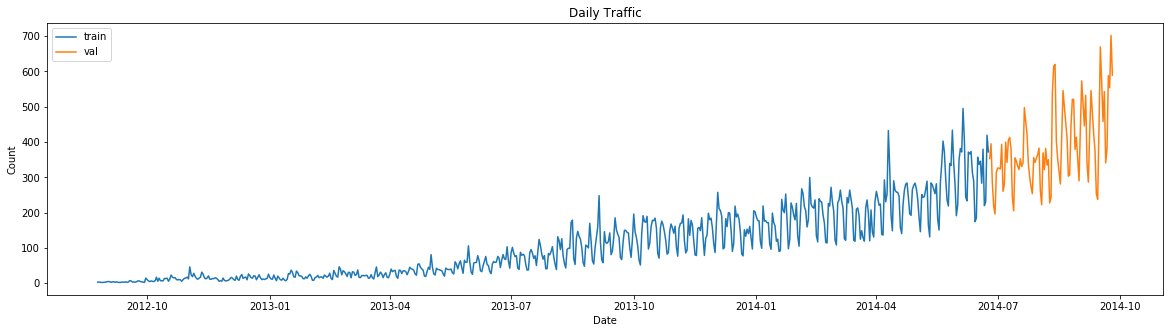

In [39]:
plt.figure(figsize=(20,5))
plt.plot(df_train.Count, label = 'train')
plt.plot(df_val.Count, label = 'val')
plt.title('Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='left')
plt.show()

The split can be visualized in the graph above

Before testing out a few models, remember that we have resampled the data into days. However our test set must submit hourly predictions. So we must figure out a way to convert daily predictions to hourly. We can generate a ratio of the mean hourly counts for the day and then divide the daily predictions according to that ratio for the day. Lets createa a function below to do this whole pipeline

In [551]:
def convert_to_hourly(daily_preds, original_test, resampled_test, original_train):
    
    resampled_test['pred'] = daily_preds
    original_train['ratio'] = original_train['Count']/original_train['Count'].sum()
    
    hour_ratio = train.groupby('hour')['ratio'].sum()
    hour_ratio =pd.DataFrame(hour_ratio)
    hour_ratio = hour_ratio.reset_index()
    
    hourly_test = pd.merge(resampled_test,original_test,on=('day','month', 'year'), how='left')
    hourly_test['hour'] = hourly_test['hour_y']
    hourly_test = hourly_test[['hour','pred','ID_y']]
    
    predictions = pd.merge(hourly_test,hour_ratio,on='hour',how='left')
    predictions['Count'] = predictions['pred']*predictions['ratio']*24
    predictions['ID'] = predictions['ID_y']
    predictions = predictions[['ID','Count']]
    predictions = predictions.set_index('ID')

    return predictions  
    

We want to create a model that will estimate the values on the validation set based on that in the training set. Some naive approached can include just using the last values in the traing set and extrapolating it, or using the moving average of the last few days in the training set and using that as an estimate. Let us see the error we get using these approaches.

### Last Value

In [40]:
df_val_pred_last = df_val.copy()
df_val_pred_last['pred'] = df_train['Count'].iloc[-1]

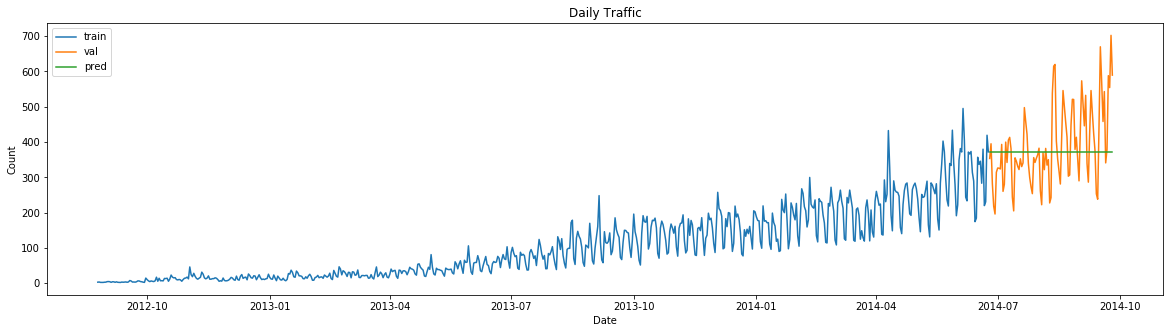

In [41]:
plt.figure(figsize=(20,5))
plt.plot(df_train.Count, label = 'train')
plt.plot(df_val.Count, label = 'val')
plt.plot(df_val_pred_last['pred'])
plt.title('Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='left')
plt.show()

In [42]:
sqrt(mean_squared_error(df_val_pred_last['pred'],df_val['Count']))

111.79050467496724

Clearly seen in the graph, the predicted value can no way estimate the values in the validation set. In the range of 100-600 that the Count variable has, an RMSE of 110 is also high.

### Moving Average

In [43]:
df_val_pred_last = df_val.copy()
df_val_pred_last['ma_10'] = df_train['Count'].rolling(10).mean().iloc[-1]
df_val_pred_last['ma_20'] = df_train['Count'].rolling(20).mean().iloc[-1]
df_val_pred_last['ma_30'] = df_train['Count'].rolling(30).mean().iloc[-1]

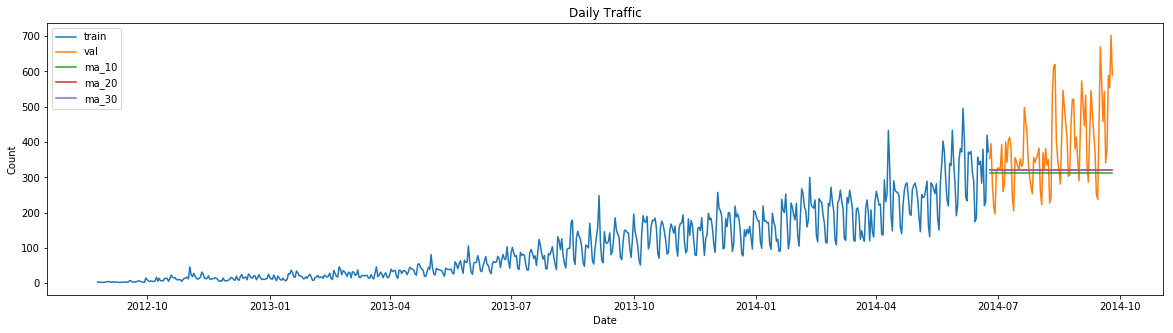

In [44]:
plt.figure(figsize=(20,5))
plt.plot(df_train.Count, label = 'train')
plt.plot(df_val.Count, label = 'val')
plt.plot(df_val_pred_last['ma_10'])
plt.plot(df_val_pred_last['ma_20'])
plt.plot(df_val_pred_last['ma_30'])
plt.title('Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='left')
plt.show()

In [45]:
print('RMSE 10Day:',sqrt(mean_squared_error(df_val_pred_last['ma_10'],df_val['Count'])))
print('RMSE 20Day:',sqrt(mean_squared_error(df_val_pred_last['ma_20'],df_val['Count'])))
print('RMSE 30Day:',sqrt(mean_squared_error(df_val_pred_last['ma_30'],df_val['Count'])))

RMSE 10Day: 134.23733308950264
RMSE 20Day: 130.44984977550422
RMSE 30Day: 129.6495809983456


The Moving averages are no good. In fact they perform even worse than the last value method.

### Autoregression Integrated Moving Average (ARIMA)

One of the most widely used time series model. We will try to estimate the counts by estimating the parameters of ARIMA on the training data and extrapolating that to the test. Now to use ARIMA, we need to make sure that the series is stationary. Let us see if we find any trend or seasonality.

Let us decompose the series into components to visualize the trends

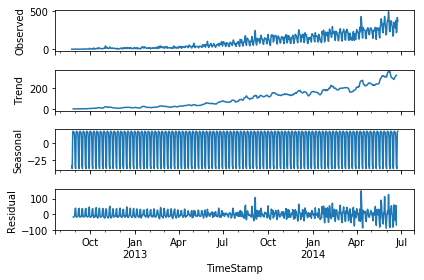

In [240]:
sm.tsa.seasonal_decompose(df_train['Count']).plot()
plt.show()

There seems to be a distinct upward trend and a seasonal component to our counts. We will have to remove it.

We can also perform the Dickey Fuller test to check for stationarity.

In [268]:
def dicky_fuller(timeseries):
    dftest = adfuller(timeseries)

    print('Test Statistic:',dftest[0])
    for i in dftest[4]:
        print(f"Critical Value {i}: {dftest[4][i]}")
dicky_fuller(train['Count'])

Test Statistic: -4.456560536856805
Critical Value 1%: -3.430708525404171
Critical Value 5%: -2.861698454786869
Critical Value 10%: -2.5668543412994906


Since the test statistic is less than the critical values, we can say that the NULL hypothesis can be rejected and that the series is stationary. However in the graph we do notice a  slight trend. Let us try to remove it just in case.

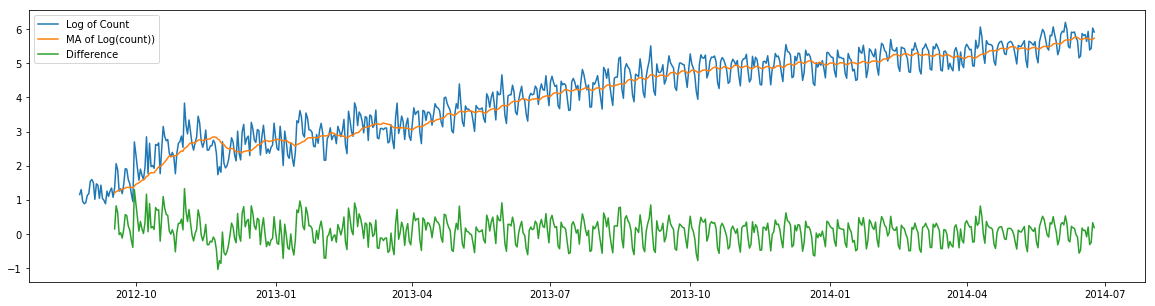

In [297]:
train_log = np.log(df_train['Count'])
val_log = np.log(df_val['Count'])
train_log_mean = pd.rolling_mean(np.log(df_train['Count']),window=24)
train_log_moving_avg_diff = (train_log - train_log_mean).dropna()
plt.figure(figsize=(20,5))
plt.plot(train_log,label='Log of Count')
plt.plot(train_log_mean,label='MA of Log(count))')
plt.plot(train_log_moving_avg_diff,label='Difference')
plt.legend()

In [295]:
dicky_fuller(train_log_moving_avg_diff)

Test Statistic: -5.861645522775971
Critical Value 1%: -3.440856177517568
Critical Value 5%: -2.86617548304384
Critical Value 10%: -2.56923863104


The Dicky Fuller test shows promissing results. Now let us try to stabilize the mean and check its stationarity.

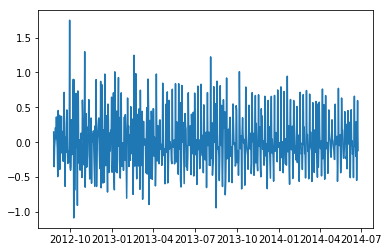

In [305]:
train_log_diff = train_log - train_log.shift(1)
plt.plot(train_log_diff.dropna())

In [307]:
dicky_fuller(train_log_diff.dropna())

Test Statistic: -8.237567849678868
Critical Value 1%: -3.4404817800778034
Critical Value 5%: -2.866010569916275
Critical Value 10%: -2.569150763698369


The results are quite satisfactory.

Let us now proceed to fit the ARIMA model from what we have learnt in the analysis above. We will plot ACF and PACF to obtain the values for the parameters of the model.

In [309]:
acf_plot = acf(train_log_diff.dropna(),nlags=24)
pacf_plot = pacf(train_log_diff.dropna(),nlags=24)

(0, 10)

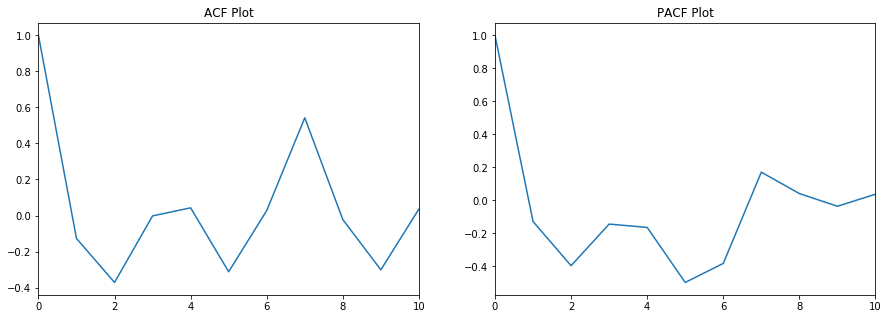

In [353]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(acf_plot)
ax[0].set_title('ACF Plot')
ax[0].set_xlim(0,10)
ax[1].plot(pacf_plot)
ax[1].set_title('PACF Plot')
ax[1].set_xlim(0,10)

We see that in both ACF and PACF, the correlation drops significantly after lag 1. We can say that the p and q value for the ARIMA model is 1. 

Lets Build the AR model first

In [483]:
model_ar = ARIMA(train_log,(2,1,0))
result_ar = model_ar.fit(display=False)

Text(0.5,1,'AR Model')

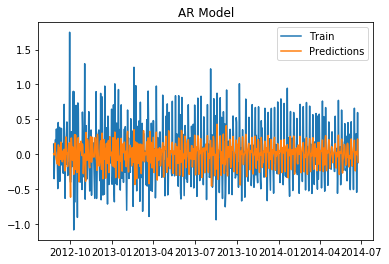

In [484]:
plt.plot(train_log_diff, label='Train')
plt.plot(result_ar.fittedvalues,label='Predictions')
plt.legend()
plt.title('AR Model')

Lets try and predict on the validation set

In [500]:
val_ar_pred = result_ar.predict(start = '2014-06-25',end='2014-09-25')
val_ar_pred = val_ar_pred.cumsum().shift().fillna(0)

In [501]:
val_ar_pred1 = pd.Series(np.ones(df_val.shape[0])*np.log(df_val['Count'])[0],index=df_val.index)
val_ar_pred1 = val_ar_pred1.add(val_ar_pred,fill_value=0)
val_ar_pred = np.exp(val_ar_pred1)

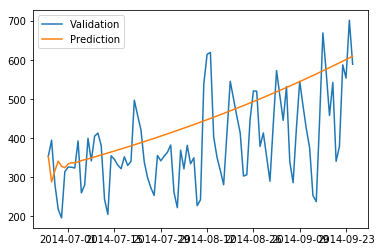

In [502]:
plt.plot(df_val['Count'],label='Validation')
plt.plot(val_ar_pred,label='Prediction')
plt.legend()

In [503]:
print('RMSE AR Model:',np.sqrt(mean_squared_error(df_val['Count'],val_ar_pred)))

RMSE AR Model: 115.22836717703987


Ok So our AR model does a decent job at predicint the validation set. We get a better RMSE score than the simple model.

Let us try with an MA model

Text(0.5,1,'MA Model')

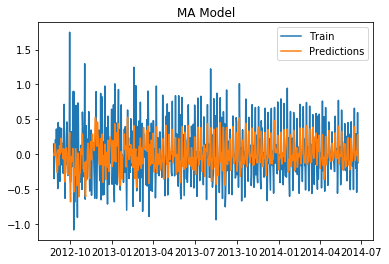

In [490]:
model_ma = ARIMA(train_log,(0,1,2))
result_ma = model_ma.fit(display=False)
plt.plot(train_log_diff, label='Train')
plt.plot(result_ma.fittedvalues,label='Predictions')
plt.legend()
plt.title('MA Model')

In [496]:
val_ma_pred = result_ma.predict(start = '2014-06-25',end='2014-09-25')
val_ma_pred = val_ma_pred.cumsum().shift().fillna(0)
val_ma_pred1 = pd.Series(np.ones(df_val.shape[0])*np.log(df_val['Count'])[0],index=df_val.index)
val_ma_pred1 = val_ma_pred1.add(val_ma_pred,fill_value=0)
val_ma_pred = np.exp(val_ma_pred1)

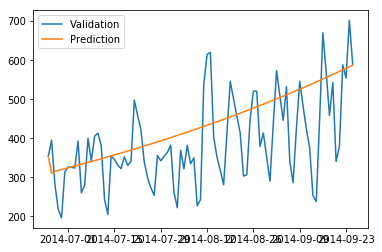

In [498]:
plt.plot(df_val['Count'],label='Validation')
plt.plot(val_ma_pred,label='Prediction')
plt.legend()

In [504]:
print('RMSE MA Model:',np.sqrt(mean_squared_error(df_val['Count'],val_ma_pred)))

RMSE MA Model: 106.94776869356332


The MA model performs much better. Let us now combine the two.

Text(0.5,1,'ARIMA Model')

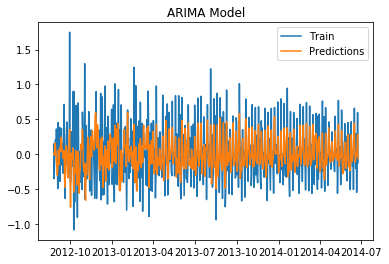

In [505]:
model_arima = ARIMA(train_log,(2,1,2))
result_arima = model_arima.fit(display=False)
plt.plot(train_log_diff, label='Train')
plt.plot(result_arima.fittedvalues,label='Predictions')
plt.legend()
plt.title('ARIMA Model')

In [508]:
val_arima_pred = result_arima.predict(start = '2014-06-25',end='2014-09-25')
val_arima_pred = val_arima_pred.cumsum().shift().fillna(0)
val_arima_pred1 = pd.Series(np.ones(df_val.shape[0])*np.log(df_val['Count'])[0],index=df_val.index)
val_arima_pred1 = val_ma_pred1.add(val_arima_pred,fill_value=0)
val_arima_pred = np.exp(val_arima_pred1)

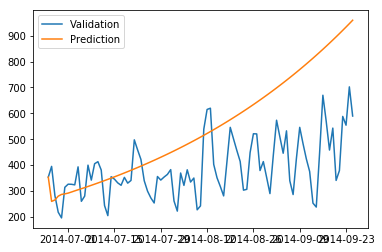

In [509]:
plt.plot(df_val['Count'],label='Validation')
plt.plot(val_arima_pred,label='Prediction')
plt.legend()

Nope, it looks lke the model is learning the trend but not the seasonality. Let us use the SARIMAX model to see if it performs better.

In [522]:
model_sarima = sm.tsa.statespace.SARIMAX(df_train['Count'],order=(2,1,4),seasonal_order=(0,1,1,7)).fit()

val_sarima_pred = model_sarima.predict(start = '2014-06-24',end='2014-09-25')

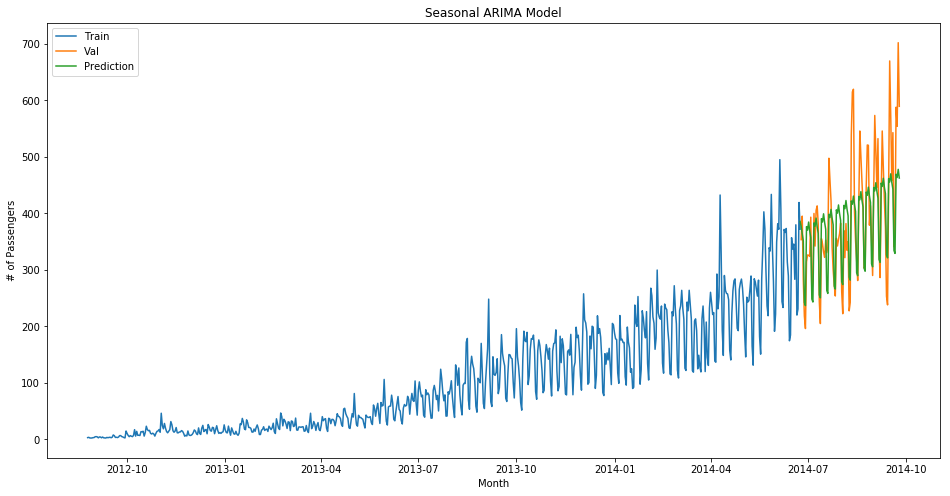

In [558]:
plt.figure(figsize=(16,8))
plt.title('Seasonal ARIMA Model')
plt.xlabel('Month')
plt.ylabel('# of Passengers')
plt.plot(df_train['Count'],label='Train')
plt.plot(df_val['Count'],label='Val')
plt.plot(val_sarima_pred,label='Prediction')
plt.legend()

In [528]:
print('RMSE SARIMA Model:',np.sqrt(mean_squared_error(df_val['Count'],val_sarima_pred[1:])))

RMSE SARIMA Model: 70.40430296407342


Including the Seasonality helped a lot. In fact this is the best performance of all the models we tried.

Now let us use this model to predict the number of passengers in the next 7 months.

In [562]:
model_sarima = sm.tsa.statespace.SARIMAX(train_resampled['Count'],order=(2,1,4),seasonal_order=(0,1,1,7)).fit()
test_sarima_pred = model_sarima.predict(start = '2014-09-25',end='2015-04-26')

In [564]:
test_sarima_pred = test_sarima_pred[1:]

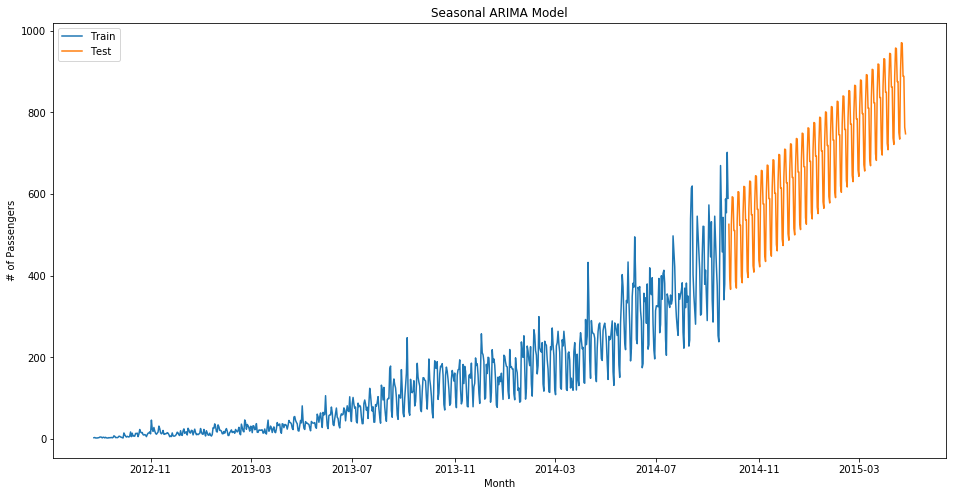

In [569]:
plt.figure(figsize=(16,8))
plt.title('Seasonal ARIMA Model')
plt.xlabel('Month')
plt.ylabel('# of Passengers')
plt.plot(train_resampled['Count'],label='Train')
plt.plot(test_sarima_pred,label='Test')
plt.legend()

In [575]:
submission = convert_to_hourly(test_sarima_pred, test, test_resampled, train)

In [577]:
submission.to_csv('arimasubmissions.csv')

This appraoch received a Leaderboard RMSE Score of 166. And the solution ranked at 150 out of 18244 participants.

## Conclusion

In this project we predicted the number of passengers a travel service would have in the coming 7 months based on the past data of a little over 3 years. We went through a lot of data exploraion using the timeseries and built a few models to try and predict the validation set with the lowest RMSE. We concluded that the Seasonal ARIMA is best suited and could generalize the best. I will summarize the scores of he varrious models below.

|          Model           |         RMSE         |
|--------------------------|----------------------|
|   Naive Last Value       |        111.79        |
|   10 Day Moving Avereage |        134.23        |
|   20 Day Moving Avereage |        130.44        |
|   30 Day Moving Avereage |        129.64        |
|       Autoregression     |        115.22        |
|Moving Average Integrated |        106.94        |
|          SARIMA          |        70.40        |

In [ ]:
SARIMA Model: 